# Tetracubes (shape classification)

This tutorial demonstrates how to use E3x to construct a simple $\mathrm{E}(3)$-equivariant neural network for shape classification. In this toy example, we want to classify <a href="https://en.wikipedia.org/wiki/Polycube">tetracubes</a>. The tetracubes are three-dimensional shapes consisting of exactly four cubes, with each cube touching the side of another cube with at least one of its sides. The following eight shapes are possible (click & drag to rotate):

<!--- Included html files will be displayed in the docs. --->
<iframe src="../_static/tetracubes.html" width="696" height="348" frameBorder="0" scrolling="no"></iframe> 

First, all necessary packages are imported.

In [1]:
import functools
import e3x
from flax import linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Next, we define all possible tetracube shapes (see visualization above). To keep things simple, each cube is represented by a single point at its center, such that a tetracube shape can be specified by four points.

In [2]:
# Definition for all eight tetracubes (unit cube midpoints).
tetracubes = jnp.asarray([
  # Line.
  [ [ -1.50,  0.00,  0.00 ], [ -0.50,  0.00,  0.00 ],
    [  0.50,  0.00,  0.00 ], [  1.50,  0.00,  0.00 ] ],
  # Square.
  [ [ -0.50, -0.50,  0.00 ], [ -0.50,  0.50,  0.00 ],
    [  0.50,  0.50,  0.00 ], [  0.50, -0.50,  0.00 ] ],
  # S/Z-shape.
  [ [ -1.00,  0.50,  0.00 ], [  0.00,  0.50,  0.00 ],
    [  0.00, -0.50,  0.00 ], [  1.00, -0.50,  0.00 ] ],
  # L/J-shape.
  [ [ -0.75, -0.75,  0.00 ], [ -0.75,  0.25,  0.00 ],
    [  0.25,  0.25,  0.00 ], [  1.25,  0.25,  0.00 ] ],
  # T-shape.
  [ [ -1.00,  0.25,  0.00 ], [  0.00,  0.25,  0.00 ],
    [  1.00,  0.25,  0.00 ], [  0.00, -0.75,  0.00 ] ],
  # Corner.
  [ [ -0.75,  0.25, -0.25 ], [  0.25,  0.25, -0.25 ],
    [  0.25, -0.75, -0.25 ], [  0.25,  0.25,  0.75 ] ],
  # Right screw.
  [ [ -0.50,  0.25, -0.25 ], [ -0.50,  0.25,  0.75 ],
    [  0.50,  0.25, -0.25 ], [  0.50, -0.75, -0.25 ] ],
  # Left screw.
  [ [ -0.75,  0.50, -0.25 ], [  0.25, -0.50,  0.75 ],
    [  0.25,  0.50, -0.25 ], [  0.25, -0.50, -0.25 ] ],
])

Starting from these eight basic shapes, we define a function to generate a toy dataset. To do this, we randomly draw one of the eight basic shapes and add some Gaussian noise to it. The task for our model will be to identify the shape (line, square, ...) of (noisy) tetracubes.

In [3]:
def generate_datasets(key, num_train=1000, num_valid=100, noise_scale=0.05):
  # Generate random keys.
  train_choice_key, valid_choice_key, train_noise_key, valid_noise_key = jax.random.split(key, num=4)

  # Assign a label to each tetracube.
  labels = jnp.arange(tetracubes.shape[0])

  # Randomly choose among the eight tetracubes to generate train and validation datasets.
  train_choice = jax.random.choice(train_choice_key, tetracubes.shape[0], shape=(num_train,))
  valid_choice = jax.random.choice(valid_choice_key, tetracubes.shape[0], shape=(num_valid,))
  train_shapes = jnp.take(tetracubes, train_choice, axis=0)
  valid_shapes = jnp.take(tetracubes, valid_choice, axis=0)
  train_labels = jnp.take(labels, train_choice, axis=0)
  valid_labels = jnp.take(labels, valid_choice, axis=0)
  
  # Add Gaussian noise for some variety.
  train_shapes += noise_scale * jax.random.normal(train_noise_key, shape=train_shapes.shape)
  valid_shapes += noise_scale * jax.random.normal(valid_noise_key, shape=valid_shapes.shape)
  
  # Return final train and validation datasets.
  train_data = dict(shapes=train_shapes, labels=train_labels)
  valid_data = dict(shapes=valid_shapes, labels=valid_labels)
  return train_data, valid_data

We now define a very simple equivariant model to solve this classification task using the modules in E3x. The architecture comprises the following steps:

1. Center the incoming tetracube shape (for translational invariance).

2. Featurize the tetracube shape by expanding the cube midpoints with radial-spherical basis functions. This produces a total of four feature representations, one for each of the four cubes in a given tetracube shape (the features are $\mathrm{SO(3)}$ irreps). To create a single feature representation for the whole tetracube shape, the average of the individual cube features is taken.

3. Apply two transformations that include tensor products. The first tensor product creates new $\mathrm{O}(3)$ irreps from the $\mathrm{SO}(3)$ irreps. However, there is no coupling path to produce pseudoscalar features yet. The second tensor product will also produce pseudoscalar features, which are necessary to distinguish the "left screw" and "right screw" shapes.

4. Collect the scalar and pseudoscalar features and apply an ordinary dense layer to predict logits for the eight classes of tetracubes.

In [4]:
class EquivariantModel(nn.Module):
  features = 8
  max_degree = 2

  @nn.compact
  def __call__(self, shapes):  # The 'shapes' array has shape (..., 4, 3).
    # 1. Center shapes at origin (for translational invariance).
    shapes -= jnp.mean(shapes, keepdims=True, axis=-2)   # 'shapes' still has shape (..., 4, 3).
    
    # 2. Featurize by expanding cube midpoints in basis functions and taking the mean over the 4 cubes.
    x = e3x.nn.basis( # 'x' has shape (..., 4, 1, (max_degree+1)**2, features).
      shapes,
      num=self.features,
      max_degree=self.max_degree,
      radial_fn=functools.partial(e3x.nn.triangular_window, limit=2.0),
    )
    x = jnp.mean(x, axis=-4)  # 'x' now has shape (..., 1, (max_degree+1)**2, features).
    
    # 3. Apply feature transformations.
    x = e3x.nn.TensorDense()(x)  # 'x' now has shape (..., 2, (max_degree+1)**2, features).
    x = e3x.nn.TensorDense(max_degree=0)(x)  # 'x' now has shape (..., 2, 1, features).
    # Try it: If the above line is replaced by 
    # x = e3x.nn.TensorDense(max_degree=0, include_pseudotensors=False)(x)
    # the output will have shape (..., 1, 1, features) and only contain scalar, but no pseudoscalar
    # features. With this change, the model will be unable to distinguish between the "left screw"
    # and the "right screw" shapes, since they are mirror images of each other, but otherwise identical.
    # Consequently, the prediction accuracy should go down to ~87.5%, because only 7/8 shapes can be 
    # classified correctly.
    
    # 4. Predict logits (with an ordinary Dense layer).
    x = jnp.reshape(x, (*x.shape[:-3], -1))  # Flatten, 'x' now has shape (..., 2*1*features).
    logits = nn.Dense(features=tetracubes.shape[0])(x)  # Logits has shape (..., 8).
    return logits

For comparison, we also define an ordinary (non-equivariant) model. The architecture comprises the following steps:

1. Center the incoming tetracube shape (for translational invariance).

2. Featurize the tetracube shape by simply flattening the xyz coordinates of the cube midpoints.

4. Apply a two-layer MLP.

5. Apply a final dense layer to predict logits for the eight classes of tetracubes.

In [5]:
class OrdinaryModel(nn.Module):
  features = 8

  @nn.compact
  def __call__(self, shapes):  # The 'shapes' array has shape (..., 4, 3).
    # 1. Center shapes at origin (for translational invariance).
    shapes -= jnp.mean(shapes, keepdims=True, axis=-2)  # 'shapes' still has shape (..., 4, 3).
    
    # 2. Flatten xyz coordinates (input features).
    x = jnp.reshape(shapes, (*shapes.shape[:-2], -1))  # 'x' has shape (..., 4*3).
    
    # 3. Apply transformations.
    x = nn.Dense(features=self.features)(x)  # 'x' has shape (..., features).
    x = nn.relu(x)
    x = nn.Dense(features=self.features)(x)
    x = nn.relu(x)
    
    # 4. Predict logits.
    logits = nn.Dense(features=tetracubes.shape[0])(x)  # Logits has shape (..., 8).
    return logits

Next, we define our loss function. Here, we use the cross entropy loss, as is common for classification tasks. For convenience, we also define a function to compute classification accuracy.

In [6]:
def cross_entropy_loss(logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=tetracubes.shape[0])
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

def compute_accuracy(logits, labels):
  return jnp.mean(jnp.argmax(logits, -1) == labels)

Now that we have all ingredients, let's write some boilerplate for training models.

In [7]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update'))
def train_step(model_apply, optimizer_update, batch, opt_state, params):
  def loss_fn(params):
    logits = model_apply(params, batch['shapes'])
    loss = cross_entropy_loss(logits, batch['labels'])
    return loss, logits
  (loss, logits), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  accuracy = compute_accuracy(logits, batch['labels'])
  return params, opt_state, loss, accuracy

@functools.partial(jax.jit, static_argnames=('model_apply',))
def eval_step(model_apply, batch, params):
  logits = model_apply(params, batch['shapes'])
  loss = cross_entropy_loss(logits=logits, labels=batch['labels'])
  accuracy = compute_accuracy(logits=logits, labels=batch['labels'])
  return loss, accuracy

def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  params = model.init(init_key, train_data['shapes'][0:1])
  opt_state = optimizer.init(params)
    
  # Determine the number of training steps per epoch.
  train_size = len(train_data['shapes'])
  steps_per_epoch = train_size//batch_size

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Draw random permutations for fetching batches from the train data.
    key, shuffle_key = jax.random.split(key)
    perms = jax.random.permutation(shuffle_key, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    # Loop over all batches.
    train_loss = 0.0  # For keeping a running average of the loss.
    train_accuracy = 0.0  # For keeping a running average of the accuracy.
    for i, perm in enumerate(perms):
      batch = {k: v[perm, ...] for k, v in train_data.items()}
      params, opt_state, loss, accuracy = train_step(
          model_apply=model.apply, 
          optimizer_update=optimizer.update, 
          batch=batch, 
          opt_state=opt_state, 
          params=params
      )
      train_loss += (loss - train_loss)/(i+1)
      train_accuracy += (accuracy - train_accuracy)/(i+1)
        
    # Evaluate on the test set after each training epoch.
    valid_loss, valid_accuracy = eval_step(
        model_apply=model.apply, 
        batch=valid_data,
        params=params
    )
    
    # Print progress.
    print(f"epoch: {epoch}")
    print(f"  train: loss {train_loss : 4.2f}, accuracy {train_accuracy * 100 : 6.2f}%")
    print(f"  valid: loss {valid_loss : 4.2f}, accuracy {valid_accuracy * 100 : 6.2f}%")

  # Return final model parameters.
  return params

Finally, let's create our toy dataset and choose the training hyperparameters.

In [8]:
# Initialize PRNGKey for random number generation.
key = jax.random.PRNGKey(0)

# Generate train and test datasets. 
key, data_key = jax.random.split(key)
train_data, valid_data = generate_datasets(data_key)

# Define training hyperparameters.
learning_rate = 0.005
num_epochs = 5
batch_size = 16

Now, we train the equivariant model.

In [9]:
# Train the equivariant model.
key, train_key = jax.random.split(key)
equivariant_model = EquivariantModel()
equivariant_params = train_model(
  key=train_key,
  model=equivariant_model,
  train_data=train_data,
  valid_data=valid_data,
  num_epochs=num_epochs,
  learning_rate=learning_rate, 
  batch_size=batch_size, 
)

epoch: 1
  train: loss  1.92, accuracy  23.19%
  valid: loss  1.30, accuracy  33.00%
epoch: 2
  train: loss  0.51, accuracy  80.34%
  valid: loss  0.03, accuracy  100.00%
epoch: 3
  train: loss  0.01, accuracy  99.90%
  valid: loss  0.00, accuracy  100.00%
epoch: 4
  train: loss  0.00, accuracy  100.00%
  valid: loss  0.00, accuracy  100.00%
epoch: 5
  train: loss  0.00, accuracy  100.00%
  valid: loss  0.00, accuracy  100.00%


And the ordinary model.

In [10]:
# Train the ordinary model.
key, train_key = jax.random.split(key)
ordinary_model = OrdinaryModel()
ordinary_params = train_model(
  key=train_key, 
  model=ordinary_model,
  train_data=train_data,
  valid_data=valid_data,
  num_epochs=num_epochs,
  learning_rate=learning_rate, 
  batch_size=batch_size, 
)

epoch: 1
  train: loss  1.86, accuracy  29.23%
  valid: loss  1.46, accuracy  49.00%
epoch: 2
  train: loss  1.11, accuracy  62.50%
  valid: loss  0.77, accuracy  81.00%
epoch: 3
  train: loss  0.53, accuracy  87.00%
  valid: loss  0.35, accuracy  87.00%
epoch: 4
  train: loss  0.26, accuracy  94.35%
  valid: loss  0.15, accuracy  100.00%
epoch: 5
  train: loss  0.10, accuracy  100.00%
  valid: loss  0.05, accuracy  100.00%


Both models quickly reach 100% accuracy on both train and validation datasets. At this point, you may wonder why we should bother with equivariance if the ordinary model works just as well. Recall how our toy data was generated: We started from the eight basic tetracube shapes and added some random noise for variety. Crucially, the basic shapes from which we started all had a fixed orientation. This means our ordinary model will only be able to recognize a shape if it is in the same orientation as the data we trained on. For randomly rotated shapes, we expect its performance to degrade. The equivariant model on the other hand should be able to recognize shapes in arbitrary orientations, even though it has never seen rotated shapes during training.

Let's test this hypothesis!

In [11]:
# Determine the accuracy of the equivariant and ordinary models for rotated shapes with different
# perturbation magnitudes (a perturbation of 0.0 gives identity matrices, a perturbation of 1.0 gives
# fully random rotation matrices).
perturbations = np.linspace(0.0, 1.0, num=6)
equivariant_accuracy = np.zeros(len(perturbations))
ordinary_accuracy = np.zeros(len(perturbations))

for i, perturbation in enumerate(perturbations):
  key, rotation_key = jax.random.split(key)
  rot = e3x.so3.random_rotation(rotation_key, perturbation=perturbation, num=len(valid_data['shapes']))
  rotated_shapes = jax.vmap(lambda x, r: x@r, in_axes=(0,0))(valid_data['shapes'], rot)
  rotated_valid_data = {'shapes': rotated_shapes, 'labels': valid_data['labels']}
  _, equivariant_accuracy[i] = eval_step(equivariant_model.apply, rotated_valid_data, equivariant_params)
  _, ordinary_accuracy[i] = eval_step(ordinary_model.apply, rotated_valid_data, ordinary_params)

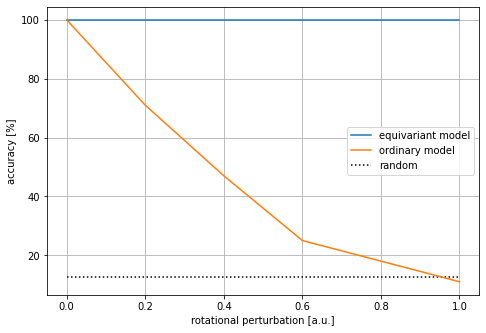

In [12]:
%matplotlib inline
# Plot the results.
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('rotational perturbation [a.u.]') 
plt.ylabel('accuracy [%]')
plt.plot(perturbations, equivariant_accuracy * 100, label='equivariant model')
plt.plot(perturbations, ordinary_accuracy * 100, label='ordinary model')
plt.hlines(y=100/tetracubes.shape[0], xmin=0.0, xmax=1.0, color='k', ls=':', label='random')
plt.legend(loc='center right')
plt.grid()

As expected, the accuracy of the ordinary model degrades quickly if we increase the rotational perturbation. If the orientation of the shapes is completely random, the ordinary model is no better than random guessing.

Of course, for this simple toy problem, it would be possible to train the ordinary model on randomly rotated shapes to make it robust to rotational perturbations. However, the point is that the equivariant model *just works* (without the need for any data augmentation). In addition, it will predict **exactly** the same class assignments independent of orientation, whereas an ordinary model trained with data augmentation will only do so **approximately**. For many applications, especially in physics and chemistry, exact equivariance with respect to rotations is extremely important (approximate equivariance is simply not good enough).